# DATA20001 Deep Learning - Group Project
## Image project

**Due Thursday, May 20, before 23:59.**

The task is to learn to assign the correct labels to a set of images.  The images are originally from a photo-sharing site and released under Creative Commons-licenses allowing sharing.  The training set contains 20 000 images. We have resized them and cropped them to 128x128 to make the task a bit more manageable.

We're only giving you the code for downloading the data. The rest you'll have to do yourselves.

Some comments and hints particular to the image project:

- One image may belong to many classes in this problem, i.e., it's a multi-label classification problem. In fact there are images that don't belong to any of our classes, and you should also be able to handle these correctly. Pay careful attention to how you design the outputs of the network (e.g., what activation to use) and what loss function should be used.

- As the dataset is pretty imbalanced, don't focus too strictly on the outputs being probabilistic. (Meaning that the right threshold for selecting the label might not be 0.5.)

- Image files can be loaded as numpy matrices for example using `imread` from `matplotlib.pyplot`. Most images are color, but a few grayscale. You need to handle the grayscale ones somehow as they would have a different number of color channels (depth) than the color ones.

- In the exercises we used e.g., `torchvision.datasets.MNIST` to handle the loading of the data in suitable batches. Here, you need to handle the dataloading yourself.  The easiest way is probably to create a custom `Dataset`. [See for example here for a tutorial](https://github.com/utkuozbulak/pytorch-custom-dataset-examples).

## Get the Data

Unzip the data if necessary.

In [1]:
import sys
import os
from os.path import join
from os.path import abspath
from os.path import split
import shutil

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision.datasets.utils import download_url
from torch.utils.data.dataset import Dataset
from torchvision import transforms, models
import zipfile

import matplotlib.pyplot as plt
from PIL import Image
import numpy as np

import re

root_dir = os.getcwd()
if root_dir not in sys.path:
    sys.path.append(root_dir)
    
train_path = 'train'

train_path_images = os.path.join(train_path, 'images')
train_path_annotations = os.path.join(train_path, 'annotations')

# check if we need to unzip data
try:
    os.listdir(train_path_images)
except OSError as e:
    data_folder_name = 'image-training-corpus+annotations'
    DATA_FOLDER_DIR = os.path.abspath(os.path.join(root_dir, data_folder_name))

    data_zip_name = 'dl2018-image-proj.zip'
    DATA_ZIP_DIR = os.path.abspath(os.path.join(DATA_FOLDER_DIR, data_zip_name))

    with zipfile.ZipFile(DATA_ZIP_DIR) as zip_f:
        zip_f.extractall(train_path)        


The above command downloaded and extracted the data files into the `train` subdirectory.

The images can be found in `train/images`, and are named as `im1.jpg`, `im2.jpg` and so on until `im20000.jpg`.

The class labels, or annotations, can be found in `train/annotations` as `CLASSNAME.txt`, where CLASSNAME is one of the fourteen classes: *baby, bird, car, clouds, dog, female, flower, male, night, people, portrait, river, sea,* and *tree*.

Each annotation file is a simple text file that lists the images that depict that class, one per line. The images are listed with their number, not the full filename. For example `5969` refers to the image `im5969.jpg`.

## Cuda

In [2]:
on_gpu = False
if torch.cuda.is_available():
    print('Using GPU!')
    # Print useful cuda errors
    os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

    # Bugfix for bug in linking of pytorch versions
    torch.cuda.current_device()

    # GPU Summary
    print('--------------------------Cuda summary--------------------------')
    print('Cuda is available: ', torch.cuda.is_available())
    print('Cuda device count: ', torch.cuda.device_count())
    print('Cuda current device index: ', torch.cuda.current_device())
    print('Cuda name of current device: ', torch.cuda.get_device_name(torch.cuda.current_device()))

    # Clear cuda cache
    print('Cuda memory before empty cache', torch.cuda.memory_cached())
    torch.cuda.empty_cache()
    print('Cuda memory after empty cache', torch.cuda.memory_cached())

    device = torch.device('cuda:0')
    on_gpu = True

else:
    print('Using CPU')
    device = torch.device('cpu')
    

Using GPU!
--------------------------Cuda summary--------------------------
Cuda is available:  True
Cuda device count:  3
Cuda current device index:  0
Cuda name of current device:  Tesla V100-SXM2-32GB
Cuda memory before empty cache 0
Cuda memory after empty cache 0


## Hyperparameters

In [3]:
NUM_EPOCHS = 100
BATCH_SIZE = 64
LEARNING_RATE = 0.01

PRE_AUGMENTATION = True # set true if images should be augmented beforehand
UNDERSAMPLE = True # randomly drop images of overrepresented classes before training 
WEIGHTS_ALT = False # choose how weights are computed (see CustomDataset)
TRANSFORM = True # set true if images should be (randomly) transformed during training

## Data Augmentation

Using [this](https://github.com/mdbloice/Augmentor) library. Saves images to Output folder in same path. Read the [documentation](https://augmentor.readthedocs.io/). 
First transforms each image in 4 different ways (rotating, flipping, etc.) and then adds the new image index to class files. 

In [4]:
if PRE_AUGMENTATION and len(os.listdir(train_path_images)) < 100000:
    
    import Augmentor
    
    def rename_and_move(train_path_images, output, incrementer):
        """ Moves the images from the output folder to the images folder.
            Renames the images in the known format (see 'Get the Data') with ascending index.
    
            train_path_images -- path to folder containing the images used for training
            output -- name of output folder where augmented images are stored
            incrementer -- current index of the last image in the train images folder
        """
        train_path_images_output = os.path.join(train_path_images, output)

        for file in os.listdir(train_path_images_output):
            # increment number for annotation file and generate new name
            new_file_name = "im" + str(int(file[18:file.index(".")]) + incrementer) + ".jpg"
            # rename (and move) 
            os.rename(os.path.join(train_path_images_output, file), 
                      os.path.join(train_path_images, new_file_name)) 


    
    i = 20000 # to put files to end of list

    p = Augmentor.Pipeline(train_path_images)

    p.flip_left_right(1.0) # flip with prob 1
    p.process()
    rename_and_move(train_path_images, "output", i)
    i += 20000

    p.flip_top_bottom(1.0) # flip with prob 1
    p.process()
    rename_and_move(train_path_images, "output", i)
    i += 20000


    p.random_erasing(1.0, 0.25) # erase 25% of image with prob 1
    p.process()
    rename_and_move(train_path_images, "output", i)
    i += 20000

    p.rotate_without_crop(1.0, 180, 180) # rotate image between -180 ° and 180° wtih no expanding or colorfilling
    p.process()
    rename_and_move(train_path_images, "output", i)
    i += 20000

    # duplicate annontations
    lines = []
    for file in os.listdir(train_path_annotations):
        # read all lines per file, can't read and write to file at the same time
        with open(os.path.join(train_path_annotations, file), 'r') as f:
                lines = f.readlines()

        with open(os.path.join(train_path_annotations, file), 'a') as f:
            # change upper bound if number of operations changed
            for j in range(1, 5):
                for line in lines:
                    f.write(str(int(line) + 20000 * j) + '\n') # append new image id


## Labels

In this section, the classes (categories) and labels (annotations) are extracted from the annotation files.  
The classes are in alphabetical order, i.e., baby, bird, ..., tree. The annotations for the images are stored in a dictionary with the image index as key and binary list as value where 1 for the ith item means that the corresponding image is part of class i. 

In [5]:
# build categories and assign annotations from files
annotation_files = os.listdir(train_path_annotations)
annotation_files.sort()
NUM_CATEGORIES = len(annotation_files)
all_images = [im for im in os.listdir(train_path_images) if re.match("im[0-9]+.jpg", im)]

# initialize with all zero
annotations = {k: np.zeros(NUM_CATEGORIES) for k in range(1, len(all_images) + 1)}
categories = {}

for file_index, file in enumerate(annotation_files):
    category, _ = file.split('.')
    categories[file_index] = category # match categories to files

    with open(os.path.join(train_path_annotations, file)) as f:
        for line in f:
            img_id = int(line.replace('\n', '')) 
            # set class in label
            annotations[img_id][file_index] = 1
            
print('Number of classes: ', NUM_CATEGORIES)

Number of classes:  14


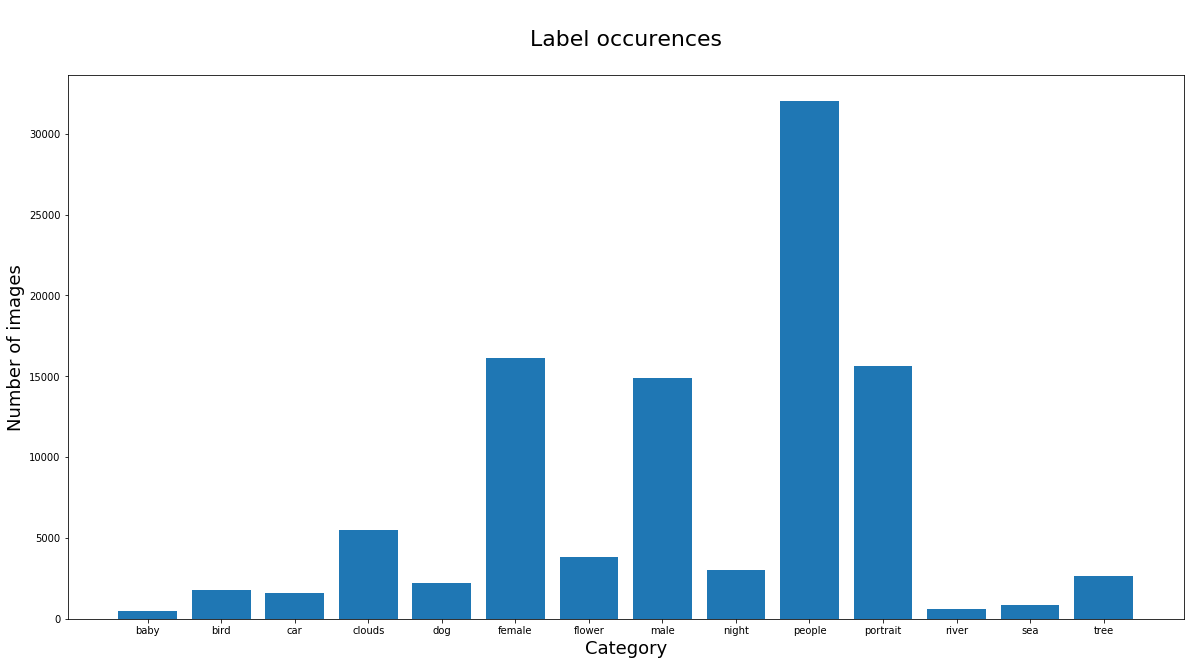

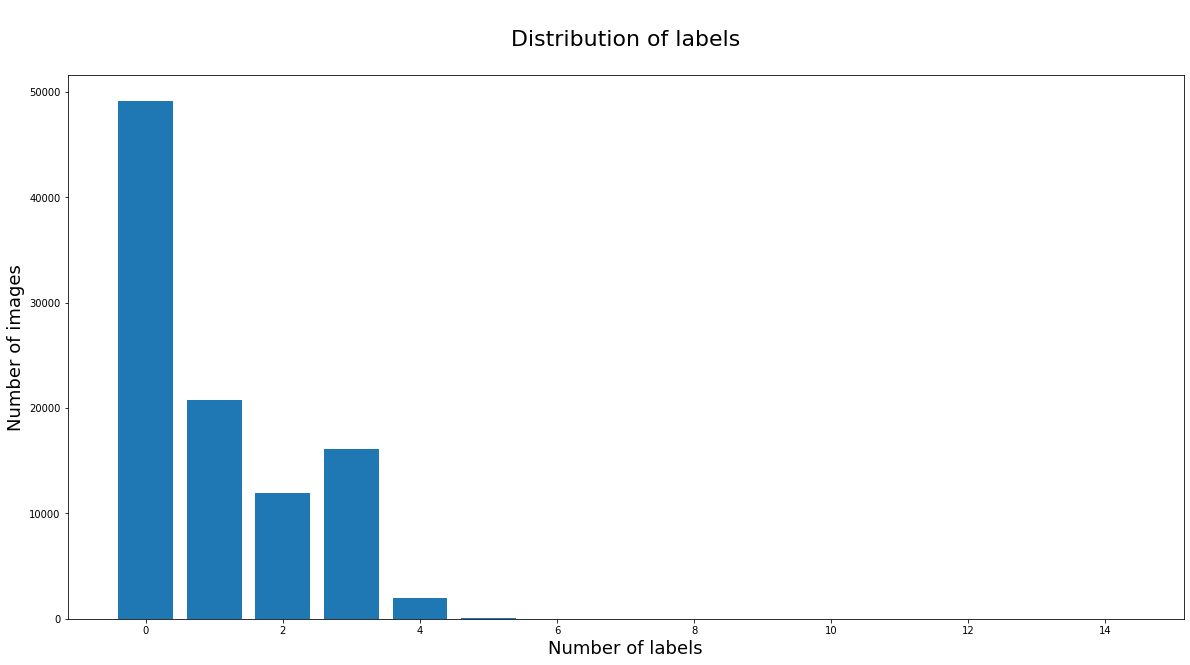

In [6]:
def plot_label_distr(labels):
    """ Plots the label occurences and distribution of a dataset.
        
        labels -- dictionary containing the labels of the dataset to be analyzed
    """
    label_values = list(labels.values())
    
    plt.figure(figsize=(20,10))
    plt.bar(categories.values(), np.sum(label_values, 0))
    plt.title("\nLabel occurences\n", fontsize=22)
    plt.xlabel("Category", fontsize=18)
    plt.ylabel("Number of images", fontsize=18)
    plt.show()
    
    num_annos = list(np.sum(label_values, 1)) # number of annotations for each image
    count_num_annos = [num_annos.count(i) for i in range(NUM_CATEGORIES + 1)] # group num_annos

    plt.figure(figsize=(20,10))
    plt.bar(range(len(count_num_annos)), count_num_annos)
    plt.title("\nDistribution of labels\n", fontsize=22)
    plt.xlabel("Number of labels", fontsize=18)
    plt.ylabel("Number of images", fontsize=18)
    plt.show()
    
plot_label_distr(annotations)

## Training and Validation Dataset

This section contains a custom dataset that deals with our images and creates a training and validation dataset. If specified, undersampling is done in order to deal with data imbalance.  
Furthermore, randomly picked images from the training set are shown 

In [7]:
class CustomDataset(Dataset):
    def __init__(self, path_images, image_idx_list, transform=transforms.ToTensor()):
        self.path_images = path_images # store path to images to get images dynamically
        self.image_idx_list = image_idx_list # list with indices of images in the dataset
        self.length = len(image_idx_list) # num of images
        
        # Only store relevent annotations
        self.labels = {}
        for (k, v) in annotations.items():
            if k in image_idx_list:
                self.labels[k] = v
                      
        # Class weights based on counts
        class_counts = sum(self.labels.values())
        self.class_counts = class_counts
        
        if WEIGHTS_ALT:
            self.weights = torch.Tensor(list(map(lambda x: sum(class_counts)/x, class_counts)))
            self.weights = self.weights / min(self.weights)
        else:
            # pos weight: negative examples/positive examples
            self.weights = torch.Tensor(list(map(lambda x: (self.length - x)/x, class_counts)))
        
        # Transformations
        # see next section
        self.transform = transform
        
    def __getitem__(self, index):
        image_index = self.image_idx_list[index]
        label = self.labels[image_index]
        img = Image.open(os.path.join(self.path_images, 'im{}.jpg'.format(image_index))).convert('RGB')
        # (apply transformations and) convert to tensor
        img = self.transform(img)

        return img, label

    def __len__(self):
        return self.length

In [8]:
np.random.seed(42)

def keep_image(index):
    """ Decides wether the image should be kept in the dataset. Keep at least one (augmented) version of each image.
        index -- index of the image
        Returns
            true if image is kept, false if it is dropped
    """
    
    if index%20000 not in kept: # keep image if no version of this image has been kept
        # drops image with probability of 0.95 if it has no annotations 
        if 1 not in annotations[index]:
            if np.random.random() > 0.05:
                return False
        # drops image with probability of 0.9 if it contains 'people' and no category with little representation
        elif annotations[index][9] == 1 and annotations[index][0] == 0 and annotations[index][11] == 0 and annotations[index][12] == 0:
            if np.random.random() > 0.1:
                return False
    kept.append(index%20000)
    return True
    
    
images = [int(file[2:file.index(".")]) for file in all_images]

if UNDERSAMPLE:
    np.random.shuffle(images) # permutate images
    kept = []
    images = [idx for idx in images if keep_image(idx)]

# Split into training and validation set
split = int(0.75 * len(images))
np.random.shuffle(images) # permutate images
train_images, val_images = images[:split], images[split:]

# Transformations for train set (no transformations for validation set)
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.ColorJitter(brightness=0.2, contrast=0.3, saturation=0.3),
    transforms.RandomAffine(degrees=20, translate=(0.1, 0.1), scale=(0.8, 1.2)),
    transforms.ToTensor()
])

# Create datasets
if TRANSFORM:
    train_dataset = CustomDataset(train_path_images, train_images, train_transform)
else:
    train_dataset = CustomDataset(train_path_images, train_images)
validation_dataset = CustomDataset(train_path_images, val_images) 

print("Training Dataset")
print("size: ", len(train_dataset))
print()

print("Validation Dataset")
print("size: ", len(validation_dataset))

Training Dataset
size:  25879

Validation Dataset
size:  8627


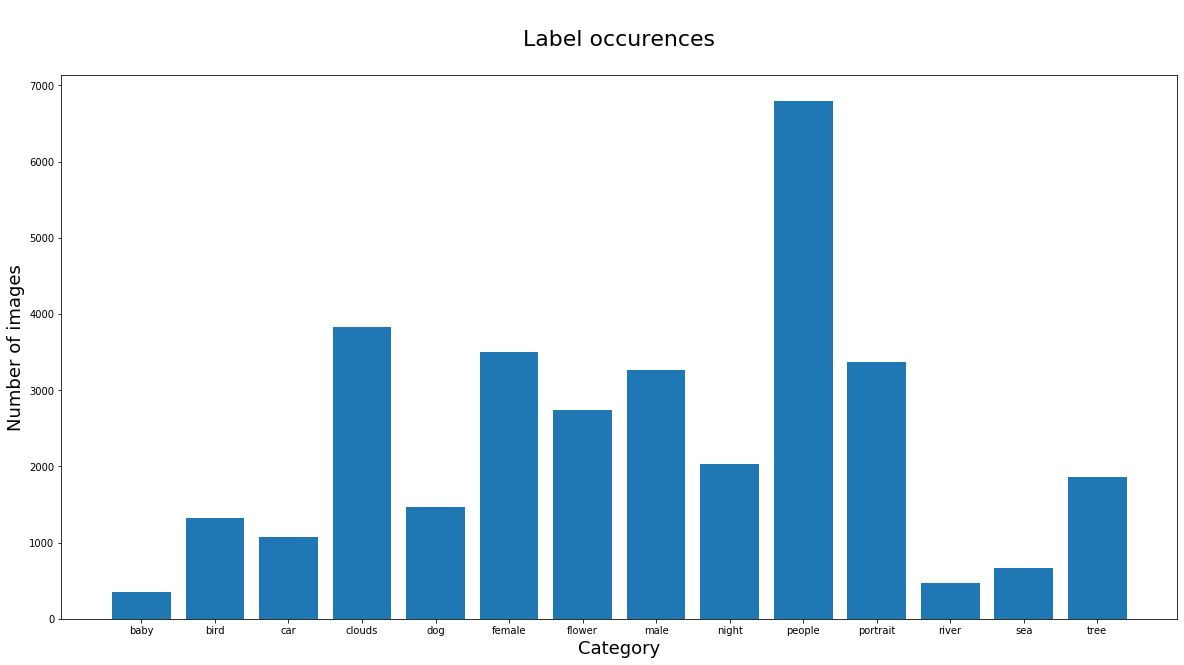

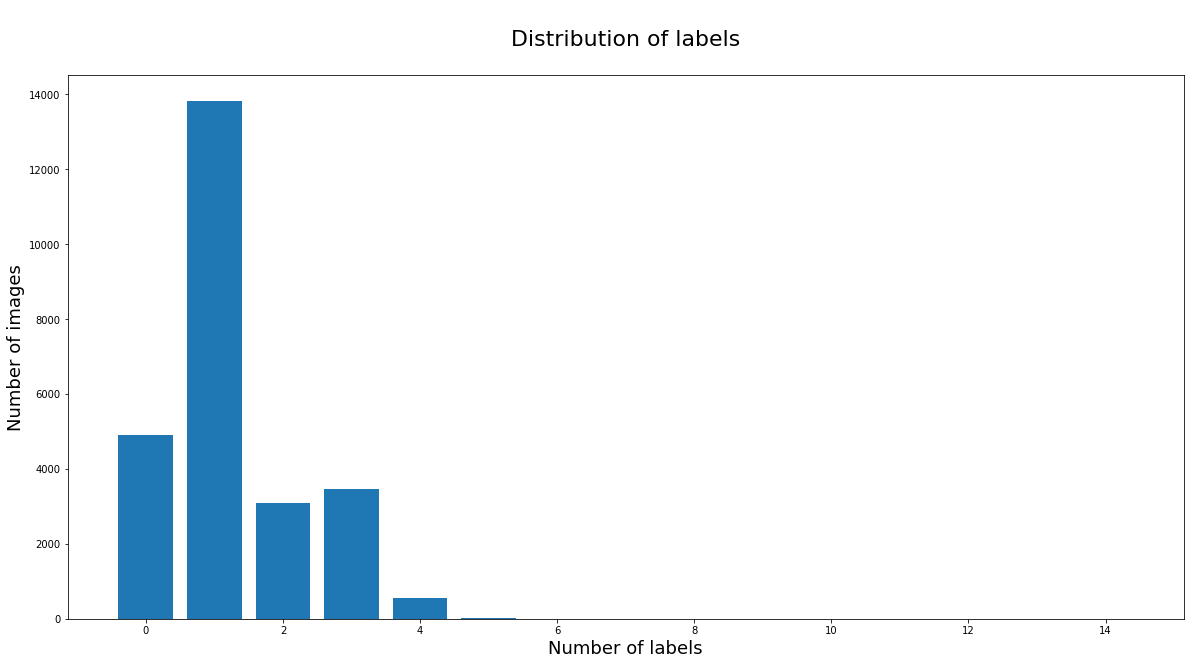

In [9]:
plot_label_distr(train_dataset.labels)

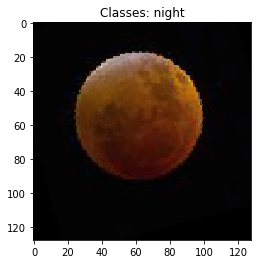

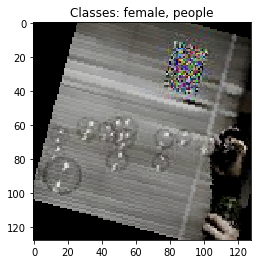

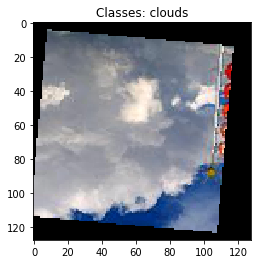

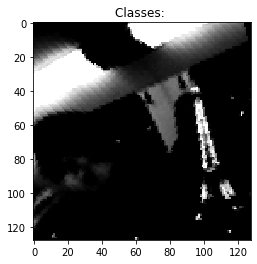

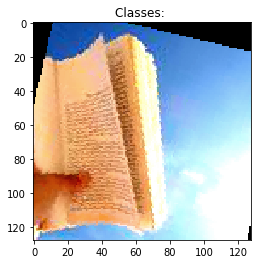

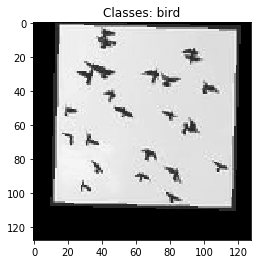

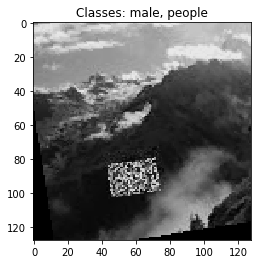

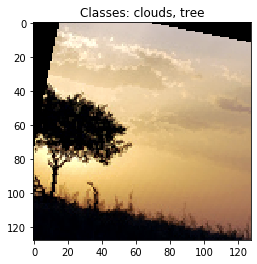

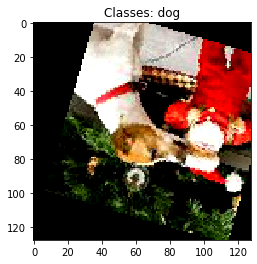

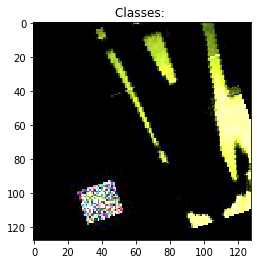

In [10]:
def get_written_label(hot_encoded_label):
    """ Converts the binary label list into the written representation.
        hot_encoded_label -- binary list of the labels
        Returns
            string with the written representation
    """
    labels = []
    for i, e in enumerate(hot_encoded_label):
        if e:
            labels.append(categories[i])
    return ', '.join(labels)

def plot_image(index, dataset):
    """ Plots an image with lables.
        index -- index of the image to be plotted
    """
    image, label = train_dataset[i]
    r, g, b = image # merge color dimensions
    image = np.dstack((r,g,b))
    plt.imshow(image)
    plt.title('Classes: '+str(get_written_label(label)))
    plt.show()

# Print random images with labels
n = 10
while n > 0:
    i = np.random.randint(0, len(train_dataset)-1)
    plot_image(i, train_dataset)
    n -= 1



## Model

In [11]:
######## convolutional layer ########
config_layer1_conv = {
    'in_channels': 3,
    'out_channels': 96,
    'kernel_size': 10, 
    'stride': 3,
    'padding': 0,   
}
config_layer1_pool = {
    'kernel_size': 5,
    'stride': 1
}

config_layer2_conv = {
    'in_channels': 96,
    'out_channels': 256,
    'kernel_size': 5, 
    'stride': 2,
    'padding': 0, 
}
config_layer2_pool = {
    'kernel_size': 3,
    'stride': 1
}

config_layer3_conv = {
    'in_channels': 256,
    'out_channels': 384,
    'kernel_size': 5, 
    'stride': 1,
    'padding': 0, 
}
config_layer3_pool = {
    'kernel_size': 3,
    'stride': 1
}

config_layer4_conv = {
    'in_channels': 384,
    'out_channels': 256,
    'kernel_size': 3, 
    'stride': 1,
    'padding': 0, 
}
config_layer4_pool = {
    'kernel_size': 3,
    'stride': 1
}

######## linear layer ########
config_layer1_linear = {
    'in_features': 4096,
    'out_features': 256
}

config_layer2_linear = {
    'in_features': 256,
    'out_features': NUM_CATEGORIES
}



class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(**config_layer1_conv),
            nn.ReLU(), 
            nn.MaxPool2d(**config_layer1_pool)
        )
        
        self.layer2 = nn.Sequential(
            nn.Conv2d(**config_layer2_conv),
            nn.ReLU(), 
            nn.MaxPool2d(**config_layer2_pool)
        )
        
        self.layer3 = nn.Sequential(
            nn.Conv2d(**config_layer3_conv),
            nn.ReLU(),
            nn.MaxPool2d(**config_layer3_pool)
        )
        
        self.layer4 = nn.Sequential(
            nn.Conv2d(**config_layer4_conv),
            nn.ReLU(),
            nn.MaxPool2d(**config_layer4_pool)
        )
        
        self.drop_out = nn.Dropout(p=0.3)
             
        self.linear1 = nn.Linear(**config_layer1_linear)
        self.linear2 = nn.Linear(**config_layer2_linear)
        
    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = x.reshape(x.size(0), -1)
        x = self.drop_out(x)
        x = self.linear1(x)
        x = self.linear2(x)
        return x

    
    
model = CNN()
model = model.to(device)
weights = train_dataset.weights.to(device)

model

CNN(
  (layer1): Sequential(
    (0): Conv2d(3, 96, kernel_size=(10, 10), stride=(3, 3))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=5, stride=1, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(96, 256, kernel_size=(5, 5), stride=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=3, stride=1, padding=0, dilation=1, ceil_mode=False)
  )
  (layer3): Sequential(
    (0): Conv2d(256, 384, kernel_size=(5, 5), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=3, stride=1, padding=0, dilation=1, ceil_mode=False)
  )
  (layer4): Sequential(
    (0): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=3, stride=1, padding=0, dilation=1, ceil_mode=False)
  )
  (drop_out): Dropout(p=0.3, inplace=False)
  (linear1): Linear(in_features=4096, out_features=256, bias=True)
  (linear2): Linear(in_features=256, out_features=14, bias=True)
)

## Train the Model



In [12]:
def train(epoch):
    """ Trains the model with the training data and prints the loss.
        epoch -- current epoch index 
    """
    print('\nTraining')
    
    model.train()
    
    for i_batch, (images, labels) in enumerate(train_loader):
        # Send data to gpu
        images, labels = images.to(device), labels.to(device)
        # Run forward pass
        outputs = model(images)       
        # Compute loss
        loss = criterion(outputs.double(), labels)
        # Backprop and perform optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if (i_batch + 1) % 10 == 0:
            print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'
                  .format(epoch + 1, 
                          NUM_EPOCHS, 
                          i_batch + 1, 
                          len(train_loader), 
                          loss
                    )
            )

In [13]:
def validate(loss_list, set_acc_list, ham_acc_list, tpr_list):
    """ Validates the model on the validation set and tracks loss and accuracy.
        loss_list -- list containing the loss average of the past epochs
        set_acc_list -- list containing the set accuracy of the past epochs
        ham_acc_list -- list containing the hamming accuracy of the past epochs
        tpr_list -- list containing the true positive ratio of the past epochs
    """
    print('\nValidation')
    
    model.eval()
    
    with torch.no_grad():
        val_loss, correct, hamming, tpr = 0., 0., 0., 0.
        for images, labels in validation_loader:
            # Send data to gpu
            images, labels = images.to(device), labels.to(device)
            
            # Run forward pass
            outputs = model(images)
            
            # Track loss
            val_loss += criterion(outputs.double(), labels)

            # Track the accuracy  
            y_pred = (torch.sigmoid(outputs) > 0.5) * 1.
            correct += (y_pred == labels).all(axis=1).sum().data.item() # number of fully(!) correctly predicted images
            hamming += (y_pred == labels).sum().data.item() # hamming score, i.e., number of correctly predicted labels
            tpr += (((y_pred == labels) * labels).sum() / labels.sum()).data.item() # true positives ratio
        
        # Compute average of the different metrics and append value to the corresponding list
        val_loss /= len(validation_loader)
        loss_list.append(val_loss)

        accuracy = 100. * correct / len(validation_loader.dataset)
        set_acc_list.append(accuracy)

        hamming_acc = 100. * hamming / (len(validation_loader.dataset)*NUM_CATEGORIES)
        ham_acc_list.append(hamming_acc)

        tp_acc = 100. * tpr / len(validation_loader)
        tpr_list.append(tp_acc)

        print('Average loss: {:.4f}, Subset Accuracy: {:.2f}%, Hamming Accuracy: {:.2f}%, True Positive Rate: {:.2f}%'
                      .format(val_loss,
                              accuracy,
                              hamming_acc,
                              tp_acc
                        )
                )

In [14]:
# Define data loaders
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                                batch_size=BATCH_SIZE,
                                                shuffle=True) 
validation_loader = torch.utils.data.DataLoader(dataset=validation_dataset,
                                                batch_size=BATCH_SIZE,
                                                shuffle=False)

# Define loss and optimizer
criterion = nn.BCEWithLogitsLoss(pos_weight=weights, reduction='mean')
optimizer = torch.optim.SGD(model.parameters(), lr=LEARNING_RATE, momentum=0.5)


loss_list, set_acc_list, ham_acc_list, tpr_list = [], [], [], []

validate(loss_list, set_acc_list, ham_acc_list, tpr_list) # initial validation before training
for epoch in range(NUM_EPOCHS):
    
    # Train and validate model
    train(epoch)
    validate(loss_list, set_acc_list, ham_acc_list, tpr_list)
    
    # Backup model every ten epochs
    if epoch % 10 == 0:
        torch.save(model.state_dict(), 'model_' + str(epoch) + '.pkl')
        print("\nsaved\n")



Validation
Average loss: 1.2495, Subset Accuracy: 0.00%, Hamming Accuracy: 68.76%, True Positive Rate: 35.02%

Training
Epoch [1/100], Step [10/405], Loss: 1.2677
Epoch [1/100], Step [20/405], Loss: 1.3112
Epoch [1/100], Step [30/405], Loss: 1.3276
Epoch [1/100], Step [40/405], Loss: 1.1399
Epoch [1/100], Step [50/405], Loss: 1.4749
Epoch [1/100], Step [60/405], Loss: 1.3222
Epoch [1/100], Step [70/405], Loss: 1.3370
Epoch [1/100], Step [80/405], Loss: 1.2397
Epoch [1/100], Step [90/405], Loss: 1.2513
Epoch [1/100], Step [100/405], Loss: 1.3966
Epoch [1/100], Step [110/405], Loss: 1.1692
Epoch [1/100], Step [120/405], Loss: 1.3296
Epoch [1/100], Step [130/405], Loss: 1.2987
Epoch [1/100], Step [140/405], Loss: 1.2303
Epoch [1/100], Step [150/405], Loss: 1.2382
Epoch [1/100], Step [160/405], Loss: 1.3538
Epoch [1/100], Step [170/405], Loss: 1.3408
Epoch [1/100], Step [180/405], Loss: 1.2322
Epoch [1/100], Step [190/405], Loss: 1.2153
Epoch [1/100], Step [200/405], Loss: 1.1694
Epoch [1

Epoch [5/100], Step [150/405], Loss: 1.1115
Epoch [5/100], Step [160/405], Loss: 1.2984
Epoch [5/100], Step [170/405], Loss: 1.2566
Epoch [5/100], Step [180/405], Loss: 1.0800
Epoch [5/100], Step [190/405], Loss: 1.1808
Epoch [5/100], Step [200/405], Loss: 1.1979
Epoch [5/100], Step [210/405], Loss: 1.1831
Epoch [5/100], Step [220/405], Loss: 1.1428
Epoch [5/100], Step [230/405], Loss: 1.1428
Epoch [5/100], Step [240/405], Loss: 1.1382
Epoch [5/100], Step [250/405], Loss: 1.3190
Epoch [5/100], Step [260/405], Loss: 1.1425
Epoch [5/100], Step [270/405], Loss: 1.1234
Epoch [5/100], Step [280/405], Loss: 1.0431
Epoch [5/100], Step [290/405], Loss: 1.0281
Epoch [5/100], Step [300/405], Loss: 1.2135
Epoch [5/100], Step [310/405], Loss: 1.1744
Epoch [5/100], Step [320/405], Loss: 1.0994
Epoch [5/100], Step [330/405], Loss: 1.0989
Epoch [5/100], Step [340/405], Loss: 1.2403
Epoch [5/100], Step [350/405], Loss: 1.1453
Epoch [5/100], Step [360/405], Loss: 1.2037
Epoch [5/100], Step [370/405], L

Epoch [9/100], Step [320/405], Loss: 1.1990
Epoch [9/100], Step [330/405], Loss: 1.1152
Epoch [9/100], Step [340/405], Loss: 1.1259
Epoch [9/100], Step [350/405], Loss: 1.0493
Epoch [9/100], Step [360/405], Loss: 0.9834
Epoch [9/100], Step [370/405], Loss: 1.0313
Epoch [9/100], Step [380/405], Loss: 1.1319
Epoch [9/100], Step [390/405], Loss: 1.0277
Epoch [9/100], Step [400/405], Loss: 1.0696

Validation
Average loss: 1.0720, Subset Accuracy: 1.87%, Hamming Accuracy: 67.01%, True Positive Rate: 73.39%

Training
Epoch [10/100], Step [10/405], Loss: 1.1844
Epoch [10/100], Step [20/405], Loss: 0.9487
Epoch [10/100], Step [30/405], Loss: 1.1435
Epoch [10/100], Step [40/405], Loss: 1.0088
Epoch [10/100], Step [50/405], Loss: 1.1494
Epoch [10/100], Step [60/405], Loss: 1.1058
Epoch [10/100], Step [70/405], Loss: 1.0180
Epoch [10/100], Step [80/405], Loss: 1.1965
Epoch [10/100], Step [90/405], Loss: 1.0045
Epoch [10/100], Step [100/405], Loss: 0.9934
Epoch [10/100], Step [110/405], Loss: 1.03

Epoch [14/100], Step [20/405], Loss: 1.0737
Epoch [14/100], Step [30/405], Loss: 1.0481
Epoch [14/100], Step [40/405], Loss: 0.9342
Epoch [14/100], Step [50/405], Loss: 1.0525
Epoch [14/100], Step [60/405], Loss: 1.1202
Epoch [14/100], Step [70/405], Loss: 0.9490
Epoch [14/100], Step [80/405], Loss: 1.1102
Epoch [14/100], Step [90/405], Loss: 1.0069
Epoch [14/100], Step [100/405], Loss: 1.0473
Epoch [14/100], Step [110/405], Loss: 1.0885
Epoch [14/100], Step [120/405], Loss: 0.9047
Epoch [14/100], Step [130/405], Loss: 0.9912
Epoch [14/100], Step [140/405], Loss: 0.9630
Epoch [14/100], Step [150/405], Loss: 1.1198
Epoch [14/100], Step [160/405], Loss: 0.9747
Epoch [14/100], Step [170/405], Loss: 0.9171
Epoch [14/100], Step [180/405], Loss: 0.9421
Epoch [14/100], Step [190/405], Loss: 0.9384
Epoch [14/100], Step [200/405], Loss: 0.9185
Epoch [14/100], Step [210/405], Loss: 0.8382
Epoch [14/100], Step [220/405], Loss: 1.0254
Epoch [14/100], Step [230/405], Loss: 1.0583
Epoch [14/100], St

Epoch [18/100], Step [150/405], Loss: 0.9951
Epoch [18/100], Step [160/405], Loss: 0.8628
Epoch [18/100], Step [170/405], Loss: 0.8926
Epoch [18/100], Step [180/405], Loss: 0.8400
Epoch [18/100], Step [190/405], Loss: 0.9229
Epoch [18/100], Step [200/405], Loss: 0.9012
Epoch [18/100], Step [210/405], Loss: 0.9122
Epoch [18/100], Step [220/405], Loss: 0.9132
Epoch [18/100], Step [230/405], Loss: 0.9341
Epoch [18/100], Step [240/405], Loss: 1.0029
Epoch [18/100], Step [250/405], Loss: 0.9007
Epoch [18/100], Step [260/405], Loss: 1.0563
Epoch [18/100], Step [270/405], Loss: 0.9003
Epoch [18/100], Step [280/405], Loss: 1.2933
Epoch [18/100], Step [290/405], Loss: 0.8600
Epoch [18/100], Step [300/405], Loss: 0.9049
Epoch [18/100], Step [310/405], Loss: 1.1621
Epoch [18/100], Step [320/405], Loss: 1.0746
Epoch [18/100], Step [330/405], Loss: 0.9917
Epoch [18/100], Step [340/405], Loss: 0.8666
Epoch [18/100], Step [350/405], Loss: 0.9571
Epoch [18/100], Step [360/405], Loss: 1.0120
Epoch [18/

Epoch [22/100], Step [270/405], Loss: 0.9419
Epoch [22/100], Step [280/405], Loss: 1.1464
Epoch [22/100], Step [290/405], Loss: 0.9206
Epoch [22/100], Step [300/405], Loss: 0.8673
Epoch [22/100], Step [310/405], Loss: 0.7960
Epoch [22/100], Step [320/405], Loss: 0.9413
Epoch [22/100], Step [330/405], Loss: 0.8585
Epoch [22/100], Step [340/405], Loss: 1.0466
Epoch [22/100], Step [350/405], Loss: 0.8667
Epoch [22/100], Step [360/405], Loss: 0.9307
Epoch [22/100], Step [370/405], Loss: 0.9947
Epoch [22/100], Step [380/405], Loss: 0.7928
Epoch [22/100], Step [390/405], Loss: 0.8169
Epoch [22/100], Step [400/405], Loss: 0.8935

Validation
Average loss: 0.9541, Subset Accuracy: 2.64%, Hamming Accuracy: 72.57%, True Positive Rate: 71.78%

Training
Epoch [23/100], Step [10/405], Loss: 0.8900
Epoch [23/100], Step [20/405], Loss: 1.0353
Epoch [23/100], Step [30/405], Loss: 0.8363
Epoch [23/100], Step [40/405], Loss: 1.0439
Epoch [23/100], Step [50/405], Loss: 0.8113
Epoch [23/100], Step [60/405]

Epoch [26/100], Step [400/405], Loss: 0.9429

Validation
Average loss: 0.9317, Subset Accuracy: 4.83%, Hamming Accuracy: 73.39%, True Positive Rate: 78.55%

Training
Epoch [27/100], Step [10/405], Loss: 0.9848
Epoch [27/100], Step [20/405], Loss: 0.8386
Epoch [27/100], Step [30/405], Loss: 0.9769
Epoch [27/100], Step [40/405], Loss: 0.8039
Epoch [27/100], Step [50/405], Loss: 0.8656
Epoch [27/100], Step [60/405], Loss: 0.9675
Epoch [27/100], Step [70/405], Loss: 0.9096
Epoch [27/100], Step [80/405], Loss: 0.8110
Epoch [27/100], Step [90/405], Loss: 0.9444
Epoch [27/100], Step [100/405], Loss: 0.8644
Epoch [27/100], Step [110/405], Loss: 0.8986
Epoch [27/100], Step [120/405], Loss: 0.8523
Epoch [27/100], Step [130/405], Loss: 0.9490
Epoch [27/100], Step [140/405], Loss: 0.8767
Epoch [27/100], Step [150/405], Loss: 0.7957
Epoch [27/100], Step [160/405], Loss: 1.0523
Epoch [27/100], Step [170/405], Loss: 0.8425
Epoch [27/100], Step [180/405], Loss: 0.9662
Epoch [27/100], Step [190/405], L

Epoch [31/100], Step [100/405], Loss: 0.7739
Epoch [31/100], Step [110/405], Loss: 0.6870
Epoch [31/100], Step [120/405], Loss: 0.7921
Epoch [31/100], Step [130/405], Loss: 0.9070
Epoch [31/100], Step [140/405], Loss: 0.8764
Epoch [31/100], Step [150/405], Loss: 0.7297
Epoch [31/100], Step [160/405], Loss: 0.8160
Epoch [31/100], Step [170/405], Loss: 0.9409
Epoch [31/100], Step [180/405], Loss: 0.8431
Epoch [31/100], Step [190/405], Loss: 0.8641
Epoch [31/100], Step [200/405], Loss: 0.8355
Epoch [31/100], Step [210/405], Loss: 0.9138
Epoch [31/100], Step [220/405], Loss: 0.7278
Epoch [31/100], Step [230/405], Loss: 0.8125
Epoch [31/100], Step [240/405], Loss: 0.7356
Epoch [31/100], Step [250/405], Loss: 1.1579
Epoch [31/100], Step [260/405], Loss: 0.9763
Epoch [31/100], Step [270/405], Loss: 0.9506
Epoch [31/100], Step [280/405], Loss: 0.8060
Epoch [31/100], Step [290/405], Loss: 0.7907
Epoch [31/100], Step [300/405], Loss: 0.9982
Epoch [31/100], Step [310/405], Loss: 0.8668
Epoch [31/

Epoch [35/100], Step [220/405], Loss: 0.6973
Epoch [35/100], Step [230/405], Loss: 0.7786
Epoch [35/100], Step [240/405], Loss: 0.8605
Epoch [35/100], Step [250/405], Loss: 0.8225
Epoch [35/100], Step [260/405], Loss: 0.7932
Epoch [35/100], Step [270/405], Loss: 0.8873
Epoch [35/100], Step [280/405], Loss: 0.7692
Epoch [35/100], Step [290/405], Loss: 0.7913
Epoch [35/100], Step [300/405], Loss: 1.1866
Epoch [35/100], Step [310/405], Loss: 0.8263
Epoch [35/100], Step [320/405], Loss: 0.6452
Epoch [35/100], Step [330/405], Loss: 0.8282
Epoch [35/100], Step [340/405], Loss: 0.7397
Epoch [35/100], Step [350/405], Loss: 0.7685
Epoch [35/100], Step [360/405], Loss: 1.0126
Epoch [35/100], Step [370/405], Loss: 0.8533
Epoch [35/100], Step [380/405], Loss: 0.8642
Epoch [35/100], Step [390/405], Loss: 0.7940
Epoch [35/100], Step [400/405], Loss: 0.7658

Validation
Average loss: 0.7736, Subset Accuracy: 6.04%, Hamming Accuracy: 76.28%, True Positive Rate: 79.46%

Training
Epoch [36/100], Step [10

Epoch [39/100], Step [350/405], Loss: 0.8312
Epoch [39/100], Step [360/405], Loss: 0.6566
Epoch [39/100], Step [370/405], Loss: 0.7348
Epoch [39/100], Step [380/405], Loss: 0.7727
Epoch [39/100], Step [390/405], Loss: 0.7003
Epoch [39/100], Step [400/405], Loss: 0.8547

Validation
Average loss: 0.7530, Subset Accuracy: 7.40%, Hamming Accuracy: 77.85%, True Positive Rate: 82.22%

Training
Epoch [40/100], Step [10/405], Loss: 0.7573
Epoch [40/100], Step [20/405], Loss: 0.6685
Epoch [40/100], Step [30/405], Loss: 0.6435
Epoch [40/100], Step [40/405], Loss: 0.8096
Epoch [40/100], Step [50/405], Loss: 0.6355
Epoch [40/100], Step [60/405], Loss: 0.7841
Epoch [40/100], Step [70/405], Loss: 1.0228
Epoch [40/100], Step [80/405], Loss: 0.8199
Epoch [40/100], Step [90/405], Loss: 0.7821
Epoch [40/100], Step [100/405], Loss: 0.8092
Epoch [40/100], Step [110/405], Loss: 0.8554
Epoch [40/100], Step [120/405], Loss: 0.8987
Epoch [40/100], Step [130/405], Loss: 0.6133
Epoch [40/100], Step [140/405], L

Epoch [44/100], Step [50/405], Loss: 0.7926
Epoch [44/100], Step [60/405], Loss: 0.7356
Epoch [44/100], Step [70/405], Loss: 0.7418
Epoch [44/100], Step [80/405], Loss: 0.7578
Epoch [44/100], Step [90/405], Loss: 0.6850
Epoch [44/100], Step [100/405], Loss: 0.7983
Epoch [44/100], Step [110/405], Loss: 0.7111
Epoch [44/100], Step [120/405], Loss: 0.7139
Epoch [44/100], Step [130/405], Loss: 0.7860
Epoch [44/100], Step [140/405], Loss: 0.8771
Epoch [44/100], Step [150/405], Loss: 0.7905
Epoch [44/100], Step [160/405], Loss: 0.7292
Epoch [44/100], Step [170/405], Loss: 0.6815
Epoch [44/100], Step [180/405], Loss: 0.7168
Epoch [44/100], Step [190/405], Loss: 0.6654
Epoch [44/100], Step [200/405], Loss: 0.7590
Epoch [44/100], Step [210/405], Loss: 0.7576
Epoch [44/100], Step [220/405], Loss: 0.6846
Epoch [44/100], Step [230/405], Loss: 0.7164
Epoch [44/100], Step [240/405], Loss: 0.6794
Epoch [44/100], Step [250/405], Loss: 0.7990
Epoch [44/100], Step [260/405], Loss: 0.6476
Epoch [44/100],

Epoch [48/100], Step [180/405], Loss: 0.7690
Epoch [48/100], Step [190/405], Loss: 0.8626
Epoch [48/100], Step [200/405], Loss: 0.6438
Epoch [48/100], Step [210/405], Loss: 0.6201
Epoch [48/100], Step [220/405], Loss: 0.8298
Epoch [48/100], Step [230/405], Loss: 0.7683
Epoch [48/100], Step [240/405], Loss: 0.7418
Epoch [48/100], Step [250/405], Loss: 0.7735
Epoch [48/100], Step [260/405], Loss: 0.7656
Epoch [48/100], Step [270/405], Loss: 0.6486
Epoch [48/100], Step [280/405], Loss: 0.6755
Epoch [48/100], Step [290/405], Loss: 0.7580
Epoch [48/100], Step [300/405], Loss: 0.6483
Epoch [48/100], Step [310/405], Loss: 0.6850
Epoch [48/100], Step [320/405], Loss: 0.9068
Epoch [48/100], Step [330/405], Loss: 0.6308
Epoch [48/100], Step [340/405], Loss: 0.7458
Epoch [48/100], Step [350/405], Loss: 0.8008
Epoch [48/100], Step [360/405], Loss: 0.6547
Epoch [48/100], Step [370/405], Loss: 0.5748
Epoch [48/100], Step [380/405], Loss: 0.7466
Epoch [48/100], Step [390/405], Loss: 0.8961
Epoch [48/

Epoch [52/100], Step [300/405], Loss: 0.7646
Epoch [52/100], Step [310/405], Loss: 0.6323
Epoch [52/100], Step [320/405], Loss: 0.6755
Epoch [52/100], Step [330/405], Loss: 0.6576
Epoch [52/100], Step [340/405], Loss: 0.6780
Epoch [52/100], Step [350/405], Loss: 0.6945
Epoch [52/100], Step [360/405], Loss: 0.6419
Epoch [52/100], Step [370/405], Loss: 0.7170
Epoch [52/100], Step [380/405], Loss: 0.5747
Epoch [52/100], Step [390/405], Loss: 0.7363
Epoch [52/100], Step [400/405], Loss: 0.7744

Validation
Average loss: 0.6449, Subset Accuracy: 11.02%, Hamming Accuracy: 80.83%, True Positive Rate: 85.72%

Training
Epoch [53/100], Step [10/405], Loss: 0.7279
Epoch [53/100], Step [20/405], Loss: 0.8220
Epoch [53/100], Step [30/405], Loss: 0.7109
Epoch [53/100], Step [40/405], Loss: 0.7153
Epoch [53/100], Step [50/405], Loss: 0.5648
Epoch [53/100], Step [60/405], Loss: 0.6774
Epoch [53/100], Step [70/405], Loss: 0.5227
Epoch [53/100], Step [80/405], Loss: 0.6661
Epoch [53/100], Step [90/405], 

Epoch [57/100], Step [10/405], Loss: 0.5873
Epoch [57/100], Step [20/405], Loss: 0.5127
Epoch [57/100], Step [30/405], Loss: 0.5448
Epoch [57/100], Step [40/405], Loss: 0.7380
Epoch [57/100], Step [50/405], Loss: 0.6154
Epoch [57/100], Step [60/405], Loss: 0.4826
Epoch [57/100], Step [70/405], Loss: 0.6907
Epoch [57/100], Step [80/405], Loss: 0.7157
Epoch [57/100], Step [90/405], Loss: 0.7415
Epoch [57/100], Step [100/405], Loss: 0.6680
Epoch [57/100], Step [110/405], Loss: 0.6770
Epoch [57/100], Step [120/405], Loss: 0.6194
Epoch [57/100], Step [130/405], Loss: 0.5838
Epoch [57/100], Step [140/405], Loss: 0.5653
Epoch [57/100], Step [150/405], Loss: 0.6433
Epoch [57/100], Step [160/405], Loss: 0.5356
Epoch [57/100], Step [170/405], Loss: 0.5915
Epoch [57/100], Step [180/405], Loss: 0.7855
Epoch [57/100], Step [190/405], Loss: 0.6125
Epoch [57/100], Step [200/405], Loss: 0.6474
Epoch [57/100], Step [210/405], Loss: 0.6159
Epoch [57/100], Step [220/405], Loss: 0.5560
Epoch [57/100], Ste

Epoch [61/100], Step [140/405], Loss: 0.5645
Epoch [61/100], Step [150/405], Loss: 0.5830
Epoch [61/100], Step [160/405], Loss: 0.7839
Epoch [61/100], Step [170/405], Loss: 0.7079
Epoch [61/100], Step [180/405], Loss: 0.6176
Epoch [61/100], Step [190/405], Loss: 0.6314
Epoch [61/100], Step [200/405], Loss: 0.6383
Epoch [61/100], Step [210/405], Loss: 0.7021
Epoch [61/100], Step [220/405], Loss: 0.6246
Epoch [61/100], Step [230/405], Loss: 0.6051
Epoch [61/100], Step [240/405], Loss: 0.4831
Epoch [61/100], Step [250/405], Loss: 0.5982
Epoch [61/100], Step [260/405], Loss: 0.5255
Epoch [61/100], Step [270/405], Loss: 0.5278
Epoch [61/100], Step [280/405], Loss: 0.5756
Epoch [61/100], Step [290/405], Loss: 0.5983
Epoch [61/100], Step [300/405], Loss: 0.5834
Epoch [61/100], Step [310/405], Loss: 0.6196
Epoch [61/100], Step [320/405], Loss: 0.6850
Epoch [61/100], Step [330/405], Loss: 0.6045
Epoch [61/100], Step [340/405], Loss: 0.4901
Epoch [61/100], Step [350/405], Loss: 0.6979
Epoch [61/

Epoch [65/100], Step [260/405], Loss: 0.5693
Epoch [65/100], Step [270/405], Loss: 0.5542
Epoch [65/100], Step [280/405], Loss: 0.6476
Epoch [65/100], Step [290/405], Loss: 0.6346
Epoch [65/100], Step [300/405], Loss: 0.5594
Epoch [65/100], Step [310/405], Loss: 0.5910
Epoch [65/100], Step [320/405], Loss: 0.5295
Epoch [65/100], Step [330/405], Loss: 0.5708
Epoch [65/100], Step [340/405], Loss: 0.5582
Epoch [65/100], Step [350/405], Loss: 0.5632
Epoch [65/100], Step [360/405], Loss: 0.6408
Epoch [65/100], Step [370/405], Loss: 0.5932
Epoch [65/100], Step [380/405], Loss: 0.6976
Epoch [65/100], Step [390/405], Loss: 0.5082
Epoch [65/100], Step [400/405], Loss: 0.4870

Validation
Average loss: 0.5954, Subset Accuracy: 17.63%, Hamming Accuracy: 85.07%, True Positive Rate: 83.95%

Training
Epoch [66/100], Step [10/405], Loss: 0.6313
Epoch [66/100], Step [20/405], Loss: 0.6235
Epoch [66/100], Step [30/405], Loss: 0.5029
Epoch [66/100], Step [40/405], Loss: 0.5669
Epoch [66/100], Step [50/40

Epoch [69/100], Step [390/405], Loss: 0.6204
Epoch [69/100], Step [400/405], Loss: 0.4902

Validation
Average loss: 0.5701, Subset Accuracy: 13.99%, Hamming Accuracy: 83.25%, True Positive Rate: 89.44%

Training
Epoch [70/100], Step [10/405], Loss: 0.6029
Epoch [70/100], Step [20/405], Loss: 0.4745
Epoch [70/100], Step [30/405], Loss: 0.6688
Epoch [70/100], Step [40/405], Loss: 0.5697
Epoch [70/100], Step [50/405], Loss: 0.6374
Epoch [70/100], Step [60/405], Loss: 0.4526
Epoch [70/100], Step [70/405], Loss: 0.6765
Epoch [70/100], Step [80/405], Loss: 0.5117
Epoch [70/100], Step [90/405], Loss: 0.6009
Epoch [70/100], Step [100/405], Loss: 0.5946
Epoch [70/100], Step [110/405], Loss: 0.5326
Epoch [70/100], Step [120/405], Loss: 0.4680
Epoch [70/100], Step [130/405], Loss: 0.4383
Epoch [70/100], Step [140/405], Loss: 0.4625
Epoch [70/100], Step [150/405], Loss: 0.5571
Epoch [70/100], Step [160/405], Loss: 0.4756
Epoch [70/100], Step [170/405], Loss: 0.4564
Epoch [70/100], Step [180/405], 

Epoch [74/100], Step [90/405], Loss: 0.6752
Epoch [74/100], Step [100/405], Loss: 0.6607
Epoch [74/100], Step [110/405], Loss: 0.6581
Epoch [74/100], Step [120/405], Loss: 0.6211
Epoch [74/100], Step [130/405], Loss: 0.4742
Epoch [74/100], Step [140/405], Loss: 0.5122
Epoch [74/100], Step [150/405], Loss: 0.3937
Epoch [74/100], Step [160/405], Loss: 0.5375
Epoch [74/100], Step [170/405], Loss: 0.4178
Epoch [74/100], Step [180/405], Loss: 0.5177
Epoch [74/100], Step [190/405], Loss: 0.4649
Epoch [74/100], Step [200/405], Loss: 0.4871
Epoch [74/100], Step [210/405], Loss: 0.5369
Epoch [74/100], Step [220/405], Loss: 0.5988
Epoch [74/100], Step [230/405], Loss: 0.6664
Epoch [74/100], Step [240/405], Loss: 0.6119
Epoch [74/100], Step [250/405], Loss: 0.4195
Epoch [74/100], Step [260/405], Loss: 0.4938
Epoch [74/100], Step [270/405], Loss: 0.5319
Epoch [74/100], Step [280/405], Loss: 0.5040
Epoch [74/100], Step [290/405], Loss: 0.5596
Epoch [74/100], Step [300/405], Loss: 0.4516
Epoch [74/1

Epoch [78/100], Step [220/405], Loss: 0.5687
Epoch [78/100], Step [230/405], Loss: 0.4829
Epoch [78/100], Step [240/405], Loss: 0.4558
Epoch [78/100], Step [250/405], Loss: 0.5043
Epoch [78/100], Step [260/405], Loss: 0.7277
Epoch [78/100], Step [270/405], Loss: 0.5005
Epoch [78/100], Step [280/405], Loss: 0.4144
Epoch [78/100], Step [290/405], Loss: 0.4581
Epoch [78/100], Step [300/405], Loss: 0.4757
Epoch [78/100], Step [310/405], Loss: 0.5696
Epoch [78/100], Step [320/405], Loss: 0.5063
Epoch [78/100], Step [330/405], Loss: 0.5047
Epoch [78/100], Step [340/405], Loss: 0.5399
Epoch [78/100], Step [350/405], Loss: 0.4920
Epoch [78/100], Step [360/405], Loss: 0.6133
Epoch [78/100], Step [370/405], Loss: 0.4826
Epoch [78/100], Step [380/405], Loss: 0.4891
Epoch [78/100], Step [390/405], Loss: 0.4409
Epoch [78/100], Step [400/405], Loss: 0.4527

Validation
Average loss: 0.5450, Subset Accuracy: 19.09%, Hamming Accuracy: 86.24%, True Positive Rate: 83.15%

Training
Epoch [79/100], Step [1

Epoch [82/100], Step [340/405], Loss: 0.4742
Epoch [82/100], Step [350/405], Loss: 0.4331
Epoch [82/100], Step [360/405], Loss: 0.5372
Epoch [82/100], Step [370/405], Loss: 0.4932
Epoch [82/100], Step [380/405], Loss: 0.5232
Epoch [82/100], Step [390/405], Loss: 0.5541
Epoch [82/100], Step [400/405], Loss: 0.4517

Validation
Average loss: 0.5187, Subset Accuracy: 22.84%, Hamming Accuracy: 87.62%, True Positive Rate: 83.22%

Training
Epoch [83/100], Step [10/405], Loss: 0.5240
Epoch [83/100], Step [20/405], Loss: 0.4611
Epoch [83/100], Step [30/405], Loss: 0.5176
Epoch [83/100], Step [40/405], Loss: 0.3686
Epoch [83/100], Step [50/405], Loss: 0.4940
Epoch [83/100], Step [60/405], Loss: 0.4287
Epoch [83/100], Step [70/405], Loss: 0.4174
Epoch [83/100], Step [80/405], Loss: 0.5108
Epoch [83/100], Step [90/405], Loss: 0.4925
Epoch [83/100], Step [100/405], Loss: 0.4590
Epoch [83/100], Step [110/405], Loss: 0.3584
Epoch [83/100], Step [120/405], Loss: 0.5124
Epoch [83/100], Step [130/405], 

Epoch [87/100], Step [40/405], Loss: 0.5837
Epoch [87/100], Step [50/405], Loss: 0.3869
Epoch [87/100], Step [60/405], Loss: 0.4175
Epoch [87/100], Step [70/405], Loss: 0.5731
Epoch [87/100], Step [80/405], Loss: 0.4756
Epoch [87/100], Step [90/405], Loss: 0.7286
Epoch [87/100], Step [100/405], Loss: 0.4643
Epoch [87/100], Step [110/405], Loss: 0.3866
Epoch [87/100], Step [120/405], Loss: 0.5092
Epoch [87/100], Step [130/405], Loss: 0.4585
Epoch [87/100], Step [140/405], Loss: 0.5301
Epoch [87/100], Step [150/405], Loss: 0.4164
Epoch [87/100], Step [160/405], Loss: 0.6093
Epoch [87/100], Step [170/405], Loss: 0.4285
Epoch [87/100], Step [180/405], Loss: 0.4659
Epoch [87/100], Step [190/405], Loss: 0.4547
Epoch [87/100], Step [200/405], Loss: 0.4168
Epoch [87/100], Step [210/405], Loss: 0.5429
Epoch [87/100], Step [220/405], Loss: 0.3861
Epoch [87/100], Step [230/405], Loss: 0.4042
Epoch [87/100], Step [240/405], Loss: 0.4446
Epoch [87/100], Step [250/405], Loss: 0.5231
Epoch [87/100], 

Epoch [91/100], Step [170/405], Loss: 0.5072
Epoch [91/100], Step [180/405], Loss: 0.3774
Epoch [91/100], Step [190/405], Loss: 0.3476
Epoch [91/100], Step [200/405], Loss: 0.3578
Epoch [91/100], Step [210/405], Loss: 0.3869
Epoch [91/100], Step [220/405], Loss: 0.5255
Epoch [91/100], Step [230/405], Loss: 0.4543
Epoch [91/100], Step [240/405], Loss: 0.3789
Epoch [91/100], Step [250/405], Loss: 0.3800
Epoch [91/100], Step [260/405], Loss: 0.4773
Epoch [91/100], Step [270/405], Loss: 0.5080
Epoch [91/100], Step [280/405], Loss: 0.4709
Epoch [91/100], Step [290/405], Loss: 0.3676
Epoch [91/100], Step [300/405], Loss: 0.3883
Epoch [91/100], Step [310/405], Loss: 0.4720
Epoch [91/100], Step [320/405], Loss: 0.4082
Epoch [91/100], Step [330/405], Loss: 0.4112
Epoch [91/100], Step [340/405], Loss: 0.3854
Epoch [91/100], Step [350/405], Loss: 0.4258
Epoch [91/100], Step [360/405], Loss: 0.4853
Epoch [91/100], Step [370/405], Loss: 0.3470
Epoch [91/100], Step [380/405], Loss: 0.4044
Epoch [91/

Epoch [95/100], Step [290/405], Loss: 0.4776
Epoch [95/100], Step [300/405], Loss: 0.4885
Epoch [95/100], Step [310/405], Loss: 0.4587
Epoch [95/100], Step [320/405], Loss: 0.4536
Epoch [95/100], Step [330/405], Loss: 0.5632
Epoch [95/100], Step [340/405], Loss: 0.7044
Epoch [95/100], Step [350/405], Loss: 0.5301
Epoch [95/100], Step [360/405], Loss: 0.4244
Epoch [95/100], Step [370/405], Loss: 0.4259
Epoch [95/100], Step [380/405], Loss: 0.4061
Epoch [95/100], Step [390/405], Loss: 0.4238
Epoch [95/100], Step [400/405], Loss: 0.4991

Validation
Average loss: 0.4954, Subset Accuracy: 25.86%, Hamming Accuracy: 89.10%, True Positive Rate: 82.08%

Training
Epoch [96/100], Step [10/405], Loss: 0.4584
Epoch [96/100], Step [20/405], Loss: 0.3712
Epoch [96/100], Step [30/405], Loss: 0.3895
Epoch [96/100], Step [40/405], Loss: 0.4026
Epoch [96/100], Step [50/405], Loss: 0.4653
Epoch [96/100], Step [60/405], Loss: 0.3832
Epoch [96/100], Step [70/405], Loss: 0.3285
Epoch [96/100], Step [80/405],

Average loss: 0.4406, Subset Accuracy: 29.31%, Hamming Accuracy: 88.60%, True Positive Rate: 89.97%

Training
Epoch [100/100], Step [10/405], Loss: 0.4234
Epoch [100/100], Step [20/405], Loss: 0.3840
Epoch [100/100], Step [30/405], Loss: 0.3901
Epoch [100/100], Step [40/405], Loss: 0.4225
Epoch [100/100], Step [50/405], Loss: 0.4670
Epoch [100/100], Step [60/405], Loss: 0.3623
Epoch [100/100], Step [70/405], Loss: 0.4194
Epoch [100/100], Step [80/405], Loss: 0.4781
Epoch [100/100], Step [90/405], Loss: 0.4511
Epoch [100/100], Step [100/405], Loss: 0.3948
Epoch [100/100], Step [110/405], Loss: 0.3462
Epoch [100/100], Step [120/405], Loss: 0.5271
Epoch [100/100], Step [130/405], Loss: 0.3203
Epoch [100/100], Step [140/405], Loss: 0.5085
Epoch [100/100], Step [150/405], Loss: 0.4080
Epoch [100/100], Step [160/405], Loss: 0.4378
Epoch [100/100], Step [170/405], Loss: 0.5642
Epoch [100/100], Step [180/405], Loss: 0.4621
Epoch [100/100], Step [190/405], Loss: 0.2885
Epoch [100/100], Step [20

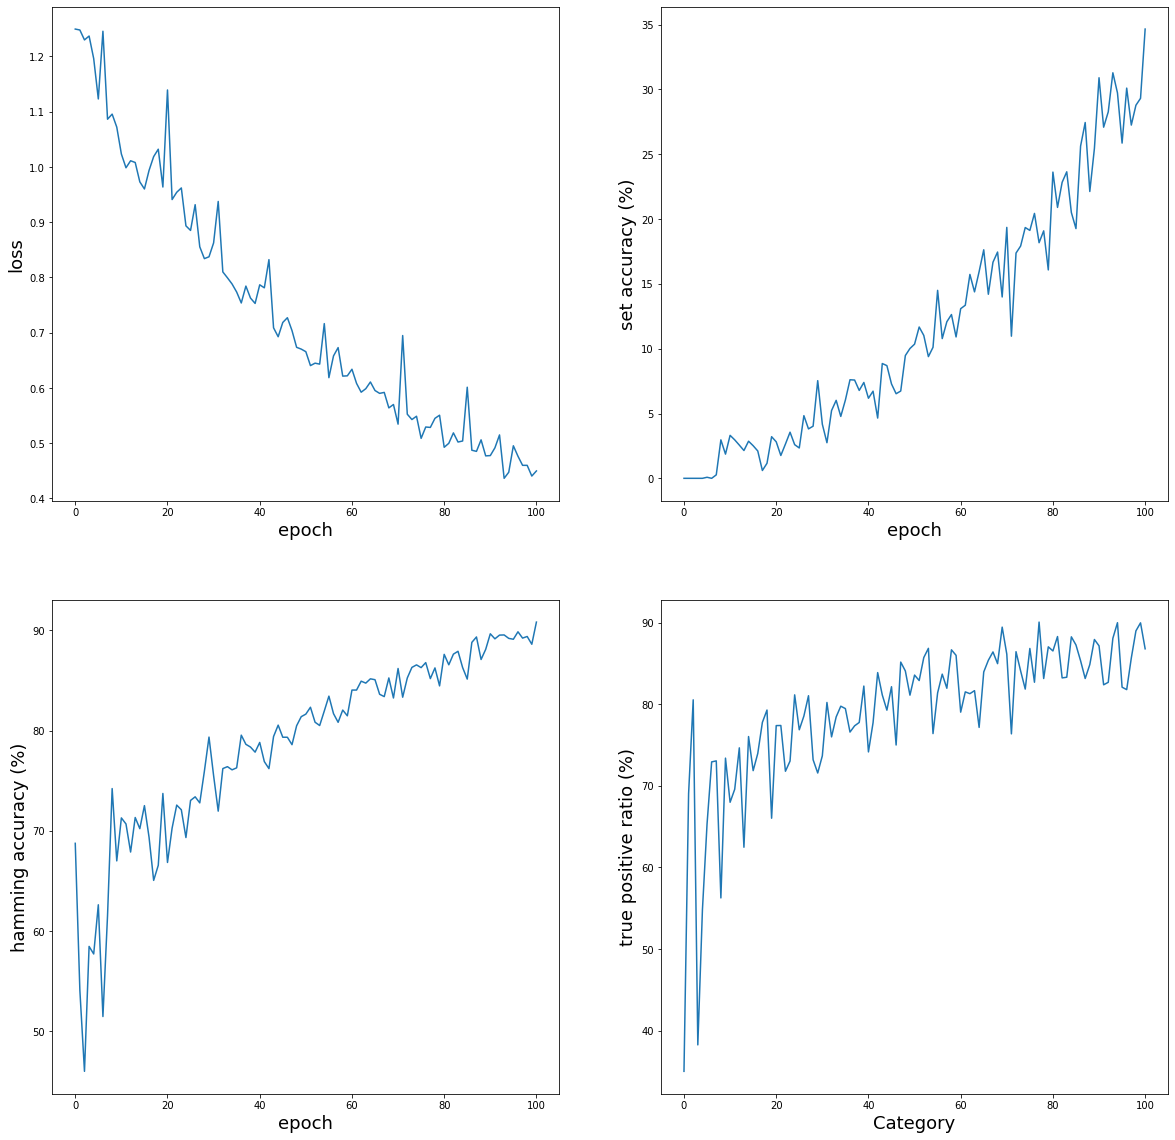

In [15]:
""" Plot training progression through the different metrics. """

plt.figure(figsize=(20, 20))
plt.subplot(221)
plt.plot(np.arange(len(loss_list)), loss_list)
plt.xlabel("epoch", fontsize=18)
plt.ylabel("loss", fontsize=18)

plt.subplot(222)
plt.plot(np.arange(len(set_acc_list)), set_acc_list)
plt.xlabel("epoch", fontsize=18)
plt.ylabel("set accuracy (%)", fontsize=18)

plt.subplot(223)
plt.plot(np.arange(len(ham_acc_list)), ham_acc_list)
plt.xlabel("epoch", fontsize=18)
plt.ylabel("hamming accuracy (%)", fontsize=18)

plt.subplot(224)
plt.plot(np.arange(len(tpr_list)), tpr_list)
plt.xlabel("Category", fontsize=18)
plt.ylabel("true positive ratio (%)", fontsize=18)

plt.show()

## Save your model

It might be useful to save your model if you want to continue your work later, or use it for inference later.

In [17]:
torch.save(model.state_dict(), 'model.pkl')

The model file should now be visible in the "Home" screen of the jupyter notebooks interface.  There you should be able to select it and press "download".  [See more here on how to load the model back](https://github.com/pytorch/pytorch/blob/761d6799beb3afa03657a71776412a2171ee7533/docs/source/notes/serialization.rst) if you want to continue training later.

## Download test set

The testset will be made available during the last week before the deadline and can be downloaded in the same way as the training set.

## Predict for test set

You should return your predictions for the test set in a plain text file.  The text file contains one row for each test set image.  Each row contains a binary prediction for each label (separated by a single space), 1 if it's present in the image, and 0 if not. The order of the labels is as follows (alphabetic order of the label names):

    baby bird car clouds dog female flower male night people portrait river sea tree

An example row could like like this if your system predicts the presense of a bird and clouds:

    0 1 0 1 0 0 0 0 0 0 0 0 0 0
    
The order of the rows should be according to the numeric order of the image numbers.  In the test set, this means that the first row refers to image `im20001.jpg`, the second to `im20002.jpg`, and so on.

In [18]:
# load model
model = CNN()
model.load_state_dict(torch.load('model.pkl'))
model = model.to(device)
weights = train_dataset.weights.to(device)

If you have the prediction output matrix prepared in `y` you can use the following function to save it to a text file.

In [19]:
np.savetxt('results.txt', y, fmt='%d')

NameError: name 'y' is not defined